In [1]:
!pip install keras

In [2]:
!pip install tensorflow 

     |████████████████████████████████| 462 kB 9.8 MB/s 


In [3]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle


In [4]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random

In [5]:
import nltk
nltk.download('punkt')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!', '.']

with open('Draft1.json') as json_data:
    intents = json.load(json_data)


In [7]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [8]:
print(len(words),len(classes),len(documents))

5888 223 370


In [9]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
# classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)


pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

370 documents
223 classes [['greetings'], ['bye'], ['creator'], ['age'], ['functions'], ['disease1'], ['disease2'], ['disease3'], ['disease4'], ['disease5'], ['disease6'], ['disease7'], ['disease8'], ['disease9'], ['disease10'], ['disease11'], ['disease12'], ['disease13'], ['disease14'], ['disease15'], ['disease16'], ['disease17'], ['disease18'], ['disease19'], ['disease20'], ['disease21'], ['disease22'], ['disease23'], ['disease24'], ['disease25'], ['disease26'], ['disease27'], ['disease28'], ['disease29'], ['disease30'], ['disease31'], ['disease32'], ['disease33'], ['disease34'], ['disease35'], ['disease36'], ['disease37'], ['disease38'], ['disease39'], ['disease40'], ['disease41'], ['disease42'], ['disease43'], ['disease44'], ['disease45'], ['disease46'], ['disease47'], ['disease48'], ['disease49'], ['disease50'], ['disease51'], ['disease52'], ['disease53'], ['disease54'], ['disease55'], ['disease56'], ['disease57'], ['disease58'], ['disease59'], ['disease60'], ['disease61'], ['dise

In [10]:

# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")


Training data created


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(np.array(train_x), np.array(train_y), test_size=0.20)

In [12]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(256, input_shape=(len(X_train[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(Y_train[0]), activation='softmax'))

model.summary()
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               276224    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 223)               28767     
                                                                 
Total params: 337,887
Trainable params: 337,887
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:


####epochs
no_epochs=200
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [14]:
# # fitting and saving the model 
# hist = model.fit(np.array(train_x), np.array(train_y), epochs=no_epochs, batch_size=5, verbose=1)
from keras.callbacks import History
history = History()
m = model.fit(X_train, Y_train, validation_data = (X_test, Y_test),
                   epochs = 50, batch_size = 5, callbacks = [history])    

Epoch 1/50
60/60 [==============================] - 3s 7ms/step - loss: 5.4065 - accuracy: 0.0068 - val_loss: 5.3941 - val_accuracy: 0.0270
Epoch 2/50
60/60 [==============================] - 0s 4ms/step - loss: 5.3087 - accuracy: 0.0372 - val_loss: 5.3719 - val_accuracy: 0.0135
Epoch 3/50
60/60 [==============================] - 0s 4ms/step - loss: 5.1731 - accuracy: 0.0405 - val_loss: 5.3526 - val_accuracy: 0.0135
Epoch 4/50
60/60 [==============================] - 0s 4ms/step - loss: 5.0448 - accuracy: 0.0338 - val_loss: 5.3198 - val_accuracy: 0.0270
Epoch 5/50
60/60 [==============================] - 0s 4ms/step - loss: 4.8312 - accuracy: 0.0541 - val_loss: 5.3671 - val_accuracy: 0.0270
Epoch 6/50
60/60 [==============================] - 0s 4ms/step - loss: 4.6992 - accuracy: 0.0608 - val_loss: 5.3386 - val_accuracy: 0.0405
Epoch 7/50
60/60 [==============================] - 0s 4ms/step - loss: 4.4082 - accuracy: 0.1081 - val_loss: 5.3080 - val_accuracy: 0.0541
Epoch 8/50
60/60 [==

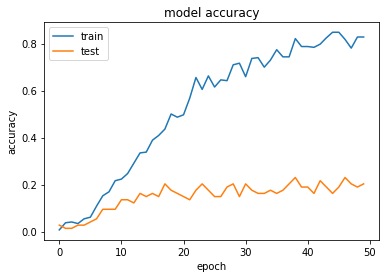

model created


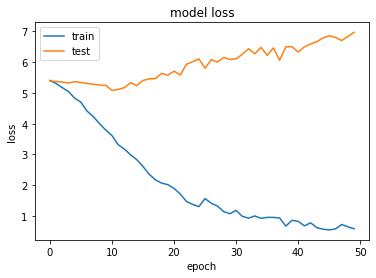

In [19]:
import matplotlib.pyplot as plt
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

model.save('chatbot_model.h5')
print("model created")